# Model Battle

**Note.** The `@threads` cell in this notebook takes about 4 hours to complete on a
2018 MacBook Pro:

We compare the predictive performance of several tumor growth models on data collected
in Laleh et al. [(2022)](https://doi.org/10.1371/journal.pcbi.1009822) "Classical
mathematical models for prediction of response to chemotherapy and immunotherapy", *PLOS
Computational Biology*". In particular, we determine whether differences observed are
statistically significant.

In addition to classical models, we include a 2D generalization of the generalized
Bertalanffy model, `bertalanffy2`, and some 1D and 2D neural ODE's. The 2D models still
model a single lesion feature, namely it's volume, but add a second latent variable
coupled to the volume, effectively making the model second order. For further details,
refer to the TumorGrowth.jl [package
documentation](https://ablaom.github.io/TumorGrowth.jl/dev/).

## Conclusions

We needed to eliminate about 10% of patient records because of failure of the neural
network models to converge before parameters went out of bounds. A bootstrap comparison
of the differences in mean absolute errors suggest that the generalized Bertalanffy model
performs significantly better than all other models, with the exception of the 1D neural
ODE. However, in pair-wise comparisons the neural ODE model was *not* significantly
better than any model. Results are summarised in the table below. Arrows point to
bootstrap winners in the top row or first column.

|                            | **logistic** | **classical\_bertalanffy** | **bertalanffy** | **bertalanffy2** | **1D neural** | **2D neural** |
|---------------------------:|-------------:|---------------------------:|----------------:|-----------------:|--------------:|--------------:|
|               **gompertz** |         draw |                       draw |               ↑ |             draw |          draw |             ← |
|               **logistic** |          n/a |                       draw |               ↑ |             draw |          draw |             ← |
| **classical\_bertalanffy** |         draw |                        n/a |               ↑ |             draw |          draw |             ← |
|            **bertalanffy** |            ← |                          ← |             n/a |                ← |          draw |             ← |
|           **bertalanffy2** |         draw |                       draw |               ↑ |              n/a |          draw |             ← |
|              **1D neural** |         draw |                       draw |            draw |             draw |           n/a |             ← |

In [ ]:
using Pkg
dir = @__DIR__
Pkg.activate(dir)
Pkg.instantiate()

using Random
using Statistics
using TumorGrowth
using Lux
using Plots
import PrettyPrint.pprint
using PrettyTables
using Bootstrap
using Serialization
using ProgressMeter
using .Threads

## Data ingestion

Collect together all records with at least 6 measurements, from the data

In [2]:
records = filter(patient_data()) do record
    record.readings >= 6
end;

Here's what a single record looks like:

In [3]:
pprint(records[13])

@NamedTuple{Pt_hashID::String, Study_Arm::InlineStrings.String15, Study_id::Int64, Arm_id::Int64, T_weeks::Vector{Float64}, T_days::Vector{Int64}, Lesion_diam::Vector{Float64}, Lesion_vol::Vector{Float64}, Lesion_normvol::Vector{Float64}, response::InlineStrings.String7, readings::Int64}(
  Pt_hashID="d9b90f39d6a0b35cbc230adadbd50753-S1",
  Study_Arm=InlineStrings.String15("Study_1_Arm_1"),
  Study_id=1,
  Arm_id=1,
  T_weeks=[0.1, 6.0, 12.0, 18.0, 
           24.0, 36.0, 40.0, 42.0, 
           48.0],
  T_days=[-16, 39, 82, 124, 165, 
          249, 277, 292, 334],
  Lesion_diam=[17.0, 18.0, 16.0, 
               9.0, 8.0, 9.0, 7.0, 
               7.0, 7.0],
  Lesion_vol=[2554.76, 3032.64, 2129.92, 
              379.08, 266.24, 379.08, 
              178.36, 178.36, 178.36],
  Lesion_normvol=[0.000414516882387563, 
                  0.00049205423531127, 
                  0.000345585416295432, 
                  6.15067794139087e-5, 
                  4.3198177036929e-5, 
          

## Neural ODEs

We define some one and two-dimensional neural ODE models we want to include in our
comparison. The choice of architecture here is somewhat ad hoc and further
experimentation might give better results.

In [4]:
network = Chain(
    Dense(1, 3, Lux.tanh, init_weight=Lux.zeros64),
    Dense(3, 1),
)

network2 = Chain(
    Dense(2, 2, Lux.tanh, init_weight=Lux.zeros64),
    Dense(2, 2),
)

n1 = neural(Xoshiro(123), network) # `Xoshiro` is a random number generator
n2 = neural2(Xoshiro(123), network2)

Neural2 model, (times, p) -> volumes, where length(p) = 14
  transform: log

## Models to be compared

In [5]:
model_exs =
    [:gompertz, :logistic, :classical_bertalanffy, :bertalanffy, :bertalanffy2, :n1, :n2]
models = eval.(model_exs)

7-element Vector{Any}:
 gompertz (generic function with 1 method)
 logistic (generic function with 1 method)
 classical_bertalanffy (generic function with 1 method)
 bertalanffy (generic function with 1 method)
 bertalanffy2 (generic function with 1 method)
 neural (12 params)
 neural2 (14 params)

## Computing prediction errors on a holdout set

In [6]:
holdouts = 2
recs = records;
errors = fill(Inf, length(recs), length(models))

p = Progress(length(recs))

@threads for i in eachindex(recs)
    record = records[i]
    times, volumes = record.T_weeks, record.Lesion_normvol
    comparison = compare(times, volumes, models; holdouts, flag_out_of_bounds=true)
    errors[i,:] = TumorGrowth.errors(comparison)
    next!(p)
end
finish!(p)

[ Info: final loss: 2.753411571211186e-9
[ Info: final loss: 0.0
[ Info: final loss: 0.00015869505880401614
[ Info: final loss: 6.721961719521866e-9
[ Info: final loss: 1.068187649137159e-5
[ Info: final loss: 4.752762105038339e-6
[ Info: final loss: 5.6920514181717044e-6
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: final loss: 9.032566018234779e-7
[ Info: Stop triggered by EarlyStopping.NumberLimit(10000) stopping criterion. 
[ Info: final loss: 3.0289050256172905e-5
[ In

In [7]:
serialize(joinpath(dir, "errors.jls"), errors)

35896

## Bootstrap comparisons (neural ODE's excluded)

Because the neural ODE errors contain more `NaN` values (because of parameters going out
of bounds), we start with a comparison that excludes them.

In [8]:
bad_error_rows = filter(axes(errors, 1)) do i
    es = errors[i,1:5]
    any(isnan, es) || any(isinf, es) || max(es...) > 0.1
end
proportion_bad = length(bad_error_rows)/size(errors, 1)
@show proportion_bad

proportion_bad = 0.0171606864274571


0.0171606864274571

That's less than 2%. Let's remove them:

In [9]:
good_error_rows = setdiff(axes(errors, 1), bad_error_rows);
errors = errors[good_error_rows,:];

Errors are evidently not normally distributed (and we were not able to transform them
to approximately normal):

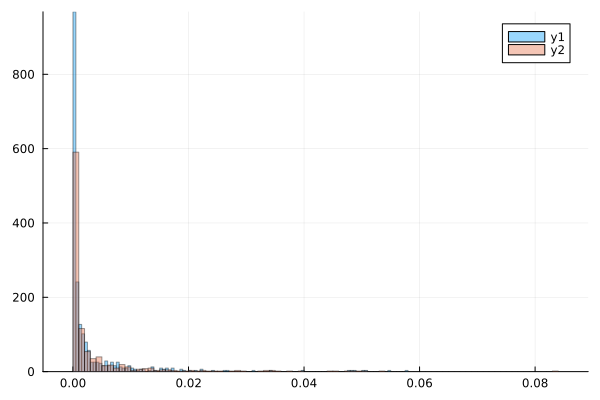

In [10]:
plt = histogram(errors[:, 1], normalize=:pdf, alpha=0.4)
histogram!(errors[:, 5], normalize=:pdf, alpha=0.4)
plt

We deem a student t-test inappopriate and instead compute bootstrap confidence intervals
for pairwise differences in model errors:

In [11]:
confidence_intervals = Array{Any}(undef, length(models) - 2, length(models) - 2)
for i in 1:(length(models) - 2)
    for j in 1:(length(models) - 2)
        b = bootstrap(
            mean,
            errors[:,i] - errors[:,j],
            BasicSampling(10000),
        )
        confidence_intervals[i,j] = only(confint(b, BasicConfInt(0.95)))[2:3]
    end
end
confidence_intervals

5×5 Matrix{Any}:
 (0.0, 0.0)                   …  (-0.00100918, -1.59482e-5)
 (-4.61964e-5, 0.000106693)      (-0.00100201, 3.95066e-5)
 (-3.28137e-5, 3.39125e-5)       (-0.000990998, -2.47283e-5)
 (-0.000195904, -3.64704e-5)     (-0.00109242, -0.000153779)
 (1.85233e-5, 0.000999058)       (0.0, 0.0)

We can interpret the confidence intervals as  follows:

- if both endpoints -ve, row index wins

- if both endpoints +ve, column index wins

- otherwise a draw

In [12]:
winner_pointer(ci) = ci == (0, 0) ? "n/a" :
    isnan(first(ci)) && isnan(last(ci)) ? "inconclusive" :
    first(ci) < 0 && last(ci) < 0 ? "←" :
    first(ci) > 0 && last(ci) > 0 ? "↑" :
    "draw"

tabular(A, model_exs) = NamedTuple{(:model, model_exs[2:end]...)}((
    model_exs[1:end-1],
    (A[1:end-1, j] for j in 2:length(model_exs))...,
))

pretty_table(
    tabular(winner_pointer.(confidence_intervals), model_exs[1:5]),
    show_subheader=false,
)

┌───────────────────────┬──────────┬───────────────────────┬─────────────┬──────────────┐
│                 model │ logistic │ classical_bertalanffy │ bertalanffy │ bertalanffy2 │
├───────────────────────┼──────────┼───────────────────────┼─────────────┼──────────────┤
│              gompertz │     draw │                  draw │           ↑ │            ← │
│              logistic │      n/a │                  draw │           ↑ │         draw │
│ classical_bertalanffy │     draw │                   n/a │           ↑ │            ← │
│           bertalanffy │        ← │                     ← │         n/a │            ← │
└───────────────────────┴──────────┴───────────────────────┴─────────────┴──────────────┘


## Bootstrap comparison of errors (neural ODE's included)

In [13]:
bad_error_rows = filter(axes(errors, 1)) do i
    es = errors[i,:]
    any(isnan, es) || any(isinf, es) || max(es...) > 0.1
end
proportion_bad = length(bad_error_rows)/size(errors, 1)
@show proportion_bad

proportion_bad = 0.1


0.1

We remove the additional 10%:

In [14]:
good_error_rows = setdiff(axes(errors, 1), bad_error_rows);
errors = errors[good_error_rows,:];

And proceed as before, but with all columns of `errors` (all models):

In [15]:
confidence_intervals = Array{Any}(undef, length(models), length(models))
for i in 1:length(models)
    for j in 1:length(models)
        b = bootstrap(
            mean,
            errors[:,i] - errors[:,j],
            BasicSampling(10000),
        )
        confidence_intervals[i, j] = only(confint(b, BasicConfInt(0.95)))[2:3]
    end
end
pretty_table(
    tabular(winner_pointer.(confidence_intervals), model_exs),
    show_subheader=false,
)

┌───────────────────────┬──────────┬───────────────────────┬─────────────┬──────────────┬──────┬────┐
│                 model │ logistic │ classical_bertalanffy │ bertalanffy │ bertalanffy2 │   n1 │ n2 │
├───────────────────────┼──────────┼───────────────────────┼─────────────┼──────────────┼──────┼────┤
│              gompertz │     draw │                  draw │           ↑ │         draw │ draw │  ← │
│              logistic │      n/a │                  draw │           ↑ │         draw │ draw │  ← │
│ classical_bertalanffy │     draw │                   n/a │           ↑ │         draw │ draw │  ← │
│           bertalanffy │        ← │                     ← │         n/a │            ← │ draw │  ← │
│          bertalanffy2 │     draw │                  draw │           ↑ │          n/a │ draw │  ← │
│                    n1 │     draw │                  draw │        draw │         draw │  n/a │  ← │
└───────────────────────┴──────────┴───────────────────────┴─────────────┴────────

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*